In [1]:
# from lfs_tree import *
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import pydot
import networkx as nx
from string import Template
import pandas as pd
import glob
import pydot
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import seaborn as sns

from IPython.display import Image, display
import matplotlib.pyplot as plt
# from IPython.display import Image, display

# the graphs this script will generate:
## 1. local quality:
            x:  deletion_factor: fix user_input_size
            x:  complaint_ratio: fix user_input_size
            y:  fix rate + confirm preserve rate + global accuracy (before after)
## 2.3 strat comparison:
      x: user input size (fix complaint ratio, fix deletion factor)
      y: runtime, global_accuracy, fix rate, confirm preserve rate

In [2]:
line_color_assignment_dict={'naive':'g','information_gain':'r', 'optimal': 'b'}

In [3]:
# functions

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

def show_trees(directory):
    treefiles = glob.glob(f'{directory}*tree_*')
    num_trees_per_strat = len(treefiles)
    for i in range(0, int(num_trees_per_strat)):
        for f in glob.glob(f'{directory}*tree_*_{i}*'):
            file = open(f)
            dot_string = file.read()
            print(f)
#             print(dot_string)
            graph = pydot.graph_from_dot_data(dot_string)[0]
            view_pydot(graph)
            print('\n')
            
def show_stats(directory):
    fs = glob.glob(f'{directory}*/*experiment_stats')
    df = pd.concat([pd.read_csv(f) for f in fs])
    return df

def determine_shape(x, shape_assignment_dict):
    return shape_assignment_dict[x]

def determine_color(x, color_assignment_dict):
    return color_assignment_dict[x]

def scatter_plots(df, x, y, xlabel, ylabel, title, shape_assignment_dict, color_assignment_dict,
                 first_legend_pos, second_legend_pos, strat_legend_rel_pos, ratio_legend_re_pos):
        
    fig, ax = plt.subplots()
    groups = df.groupby(['strat','complaint_ratio'])
    # Create a scatter plot for each group based on shape and color
    for (strat, ratio), group in groups:
        marker = shape_assignment_dict.get(strat)
        color=color_assignment_dict.get(ratio)
        ax.scatter(group[x], group[y], marker=marker, color=color, label=(strat, ratio))

    # Create separate shape and color legends
    legend_elements_1 = []
    legend_elements_2 = []

    for shape, marker in shape_assignment_dict.items():
        legend_elements_1.append(plt.Line2D([0], [0], marker=marker, color='w', label=shape, markerfacecolor='k'))
    for ratio, color in color_assignment_dict.items():
        legend_elements_2.append(plt.Line2D([0], [0], marker='o', color='w', label=ratio, markerfacecolor=color))

    # Add shape and color legends
    first_legend=ax.legend(handles=legend_elements_1, loc=first_legend_pos, 
                           bbox_to_anchor=strat_legend_rel_pos,
                           title='strategy', 
                           fontsize=13,title_fontsize=14)
    ax.legend(handles=legend_elements_2, loc=second_legend_pos, 
              bbox_to_anchor=ratio_legend_re_pos, title='complaint%',
              fontsize=13, title_fontsize=14)

    ax.add_artist(first_legend)

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)

    plt.show()
    plt.close(fig)
    

def scatter_plot_single_group_value(df, x, y, xlabel, ylabel, title, color_assignment_dict, group_col,
                                   scale, xticks=[], yticks=[]):
    fig, ax = plt.subplots()
    groups = df.groupby([group_col])
    for (g), group in groups:
        color = color_assignment_dict.get(g)
        ax.scatter(group[x], group[y], color=color, label=(g), s=10)  # Set linestyle to an empty string
    if(ylabel=='new_global_accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='black', label='accuracy_before_fix')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_yscale(scale)  # Set the y-axis to logarithmic scale
    if(yticks):
        ax.set_yticks(yticks)
    if(xticks):
        ax.set_xticks(xticks)
    # Customize y-axis ticks and labels
#     ax.set_yticks([0.1, 1, 10, 100])
#     ax.set_yticklabels(['10^-1', '10^0', '10^1', '10^2'])
    ax.legend(fontsize=13,title_fontsize=14)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    
    plt.show()
    plt.close(fig)
    plt.show()
    plt.close(fig)

    
def line_plots(df, x, y, xlabel, ylabel, title, color_assignment_dict, legend_pos,
#                group_name,
#                group_value, 
               gtype='general',
               ylim=None,
              ):
    fig, ax = plt.subplots()
#     df=df[df[group_name]==group_value]
    # Create a scatter plot for each group based on shape and color
    groups = df.groupby(['strat'])
    for strat, group in groups:
        color = color_assignment_dict.get(strat)
        print(f'color: ')
        ax.plot(group[x], group[y], color=color, label=strat)
    if(gtype=='accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='blue', label='accuracy_before_fix')
    ax.legend()
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    if(ylim):
        ax.set_ylim(ylim)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    plt.show()
    plt.close(fig)


def boxplot(df, x, y, xlabel, ylabel, title, yscale=[], xscale=[], yticks=[], xticks=[]):
    plt.figure(figsize=(8, 6))
    
    # Set the y-axis scale
    strat_list = list(df['strat'].unique())
    strat_list.sort()
        
    ax = sns.boxplot(data=df, x=x, y=y, hue='strat', hue_order=strat_list)
        # Change tick label font size for both x and y axes
    ax.tick_params(axis='both', labelsize=12)
    
    # Add a horizontal line at the specified y-coordinate (line_y)
    if ylabel == 'new_global_accuracy':
#     if line_y is not None:
        ax.axhline(y=float(df['global_accuracy'].unique()[0]), color='red', label='gloabl accuracy before fix',
                  linewidth=5)
        ax.legend(fontsize=14,title_fontsize=15)
        # Create a separate legend for the box plot (customize as needed)
        box_legend = ax.legend(title='Strat',fontsize=13,title_fontsize=15)
    
        # Combine the legends
        ax.add_artist(box_legend)
    else:
        # Create a separate legend for the box plot (customize as needed)
        ax.legend(title='Strat',fontsize=14,title_fontsize=15)
    if yscale:
        ax.set_yscale(yscale)
    
    if xscale:
        ax.set_xscale(xscale)
    
    if yticks:
        ax.set_yticks(yticks)
    
    if xticks:
        ax.set_xticks(xticks)

    plt.title(title,fontsize=20)
    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel(ylabel,fontsize=14)

    plt.savefig(f"graph_pdfs/box_{title}.pdf", format="pdf")
    plt.show()



In [4]:
# 3 strat comparison

df_3_strats= show_stats('../experiment_results_folders/3_strats/')
# /home/opc/chenjie/RBBM/rbbm_src/experiment_results_folders

In [5]:
df_3_strats.shape

(225, 25)

In [6]:
df_3_strats

,strat,rbbm_runtime,bbox_runtime,avg_tree_size_increase,user_input_size,complaint_ratio,num_complaints,num_confirmations,global_accuracy,fix_rate,confirm_preserve_rate,new_global_accuracy,prev_signaled_cnt,new_signaled_cnt,num_functions,deletion_factor,post_fix_num_funcs,num_of_funcs_processed_by_algo,complaint_reached_max,confirm_reached_max,lf_source,retrain_after_percent,retrain_accuracy_thresh,load_funcs_from_pickle,pre_deletion_threshold
0,naive,0.025,4.713,1.133333,10,0.5,5,5,0.821,0.200,0.800,0.804,1412,1412,30,0.0,30,30,False,False,intro,1,1,True,0.0
0,information_gain,0.028,4.625,1.133333,10,0.5,5,5,0.821,0.200,0.800,0.804,1412,1412,30,0.0,30,30,False,False,intro,1,1,True,0.0
0,optimal,0.035,5.040,0.733333,10,0.5,5,5,0.821,0.200,1.000,0.822,1412,1412,30,0.0,30,30,False,False,intro,1,1,True,0.0
0,naive,0.051,4.848,3.466667,20,0.5,10,10,0.821,0.300,1.000,0.819,1412,1412,30,0.0,30,30,False,False,intro,1,1,True,0.0
0,information_gain,0.072,4.779,2.400000,20,0.5,10,10,0.821,0.100,1.000,0.814,1412,1412,30,0.0,30,30,False,False,intro,1,1,True,0.0
0,optimal,0.297,4.757,1.400000,20,0.5,10,10,0.821,0.300,1.000,0.877,1412,1412,30,0.0,30,30,False,False,intro,1,1,True,0.0
0,naive,0.071,4.994,3.000000,30,0.5,15,15,0.821,0.533,0.933,0.637,1412,1412,30,0.0,30,30,False,False,intro,1,1,True,0.0
0,information_gain,0.091,4.639,1.866667,30,0.5,15,15,0.821,0.200,1.000,0.846,1412,1412,30,0.0,30,30,False,False,intro,1,1,True,0.0
0,optimal,3.966,5.181,1.266667,30,0.5,15,15,0.821,0.267,1.000,0.848,1412,1412,30,0.0,30,30,False,False,intro,1,1,True,0.0
0,naive,0.089,4.848,2.933333,40,0.5,20,20,0.821,0.300,0.850,0.838,1412,1412,30,0.0,30,30,False,False,intro,1,1,True,0.0


In [7]:
list(df_3_strats)

['strat',
 'rbbm_runtime',
 'bbox_runtime',
 'avg_tree_size_increase',
 'user_input_size',
 'complaint_ratio',
 'num_complaints',
 'num_confirmations',
 'global_accuracy',
 'fix_rate',
 'confirm_preserve_rate',
 'new_global_accuracy',
 'prev_signaled_cnt',
 'new_signaled_cnt',
 'num_functions',
 'deletion_factor',
 'post_fix_num_funcs',
 'num_of_funcs_processed_by_algo',
 'complaint_reached_max',
 'confirm_reached_max',
 'lf_source',
 'retrain_after_percent',
 'retrain_accuracy_thresh',
 'load_funcs_from_pickle',
 'pre_deletion_threshold']

In [8]:
df_3_strats.shape

(225, 25)

In [18]:
df_3_strats[df_3_strats['strat']=='optimal'].sort_values('user_input_size').groupby('user_input_size').count()

,strat,rbbm_runtime,bbox_runtime,avg_tree_size_increase,complaint_ratio,num_complaints,num_confirmations,global_accuracy,fix_rate,confirm_preserve_rate,new_global_accuracy,prev_signaled_cnt,new_signaled_cnt,num_functions,deletion_factor,post_fix_num_funcs,num_of_funcs_processed_by_algo,complaint_reached_max,confirm_reached_max,lf_source,retrain_after_percent,retrain_accuracy_thresh,load_funcs_from_pickle,pre_deletion_threshold
user_input_size,,,,,,,,,,,,,,,,,,,,,,,,
10,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
20,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
30,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
40,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
60,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
80,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
100,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


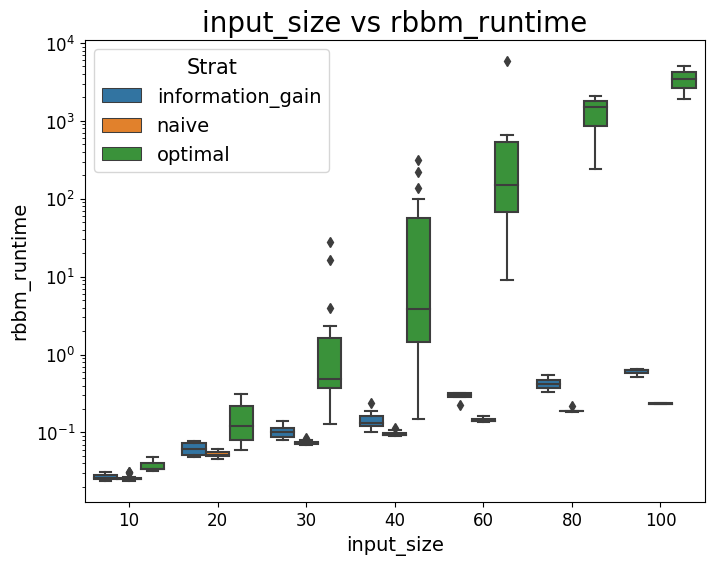

In [9]:
# scatter_plot_single_group_value(df=df_3_strats, 
#                                 x='user_input_size', 
#                                 y='rbbm_runtime', 
#                                 xlabel='input_size', 
#                                 ylabel='runtime', 
#                                 title='input_size vs runtime', 
#                                 color_assignment_dict=line_color_assignment_dict,
#                                 group_col='strat',
#                                scale='log',
#                                xticks=[10, 20, 30, 40, 60, 80, 100])
boxplot(df=df_3_strats, 
        x='user_input_size', 
        y='rbbm_runtime', 
        xlabel='input_size', 
        ylabel='rbbm_runtime', 
        title='input_size vs rbbm_runtime', 
        yscale='log',
#         xticks=[10, 20, 30, 40, 60, 80, 100]
       )

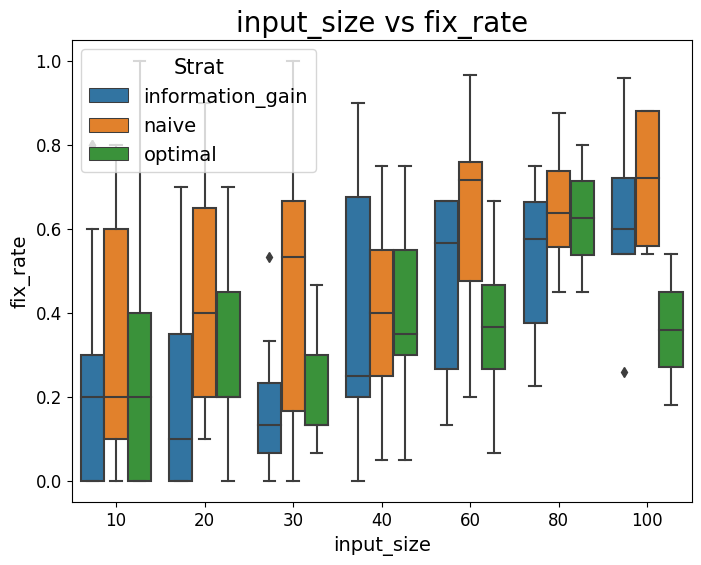

In [10]:
# scatter_plot_single_group_value(df=df_3_strats, 
#                                 x='user_input_size', 
#                                 y='fix_rate', 
#                                 xlabel='input_size', 
#                                 ylabel='fix_rate', 
#                                 title='input_size vs fix_rate', 
#                                 color_assignment_dict=line_color_assignment_dict,
#                                 group_col='strat',
#                                scale='linear',
#                                 xticks=[10, 20, 30, 40, 60, 80, 100])
boxplot(df=df_3_strats, 
        x='user_input_size', 
        y='fix_rate', 
        xlabel='input_size', 
        ylabel='fix_rate', 
        title='input_size vs fix_rate', 
#         color_assignment_dict=line_color_assignment_dict,
#         group_col='strat',
       )

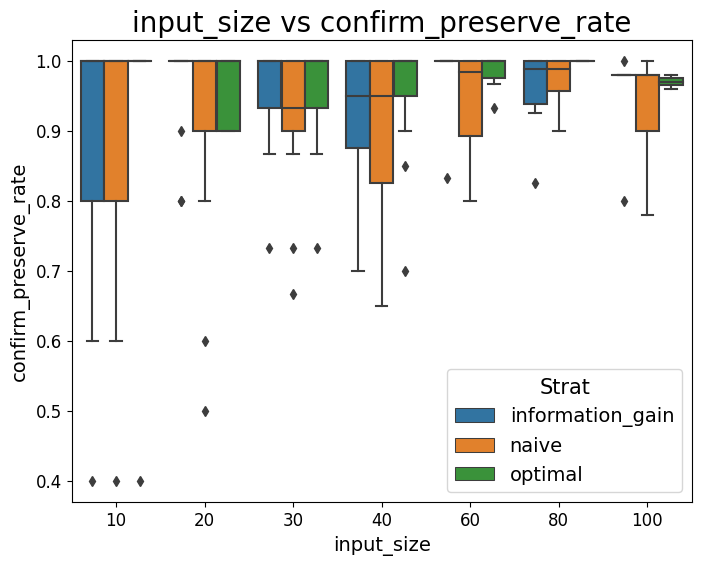

In [11]:
# scatter_plot_single_group_value(df=df_3_strats, 
#                                 x='user_input_size', 
#                                 y='confirm_preserve_rate', 
#                                 xlabel='input_size', 
#                                 ylabel='confirm_preserve_rate', 
#                                 title='input_size vs confirm_preserve_rate', 
#                                 color_assignment_dict=line_color_assignment_dict,
#                                 group_col='strat',
#                                scale='linear',
#                                 xticks=[10, 20, 30, 40, 60, 80, 100])
boxplot(df=df_3_strats, 
        x='user_input_size', 
        y='confirm_preserve_rate', 
        xlabel='input_size', 
        ylabel='confirm_preserve_rate', 
        title='input_size vs confirm_preserve_rate', 
#         color_assignment_dict=line_color_assignment_dict,
#         group_col='strat',
       )

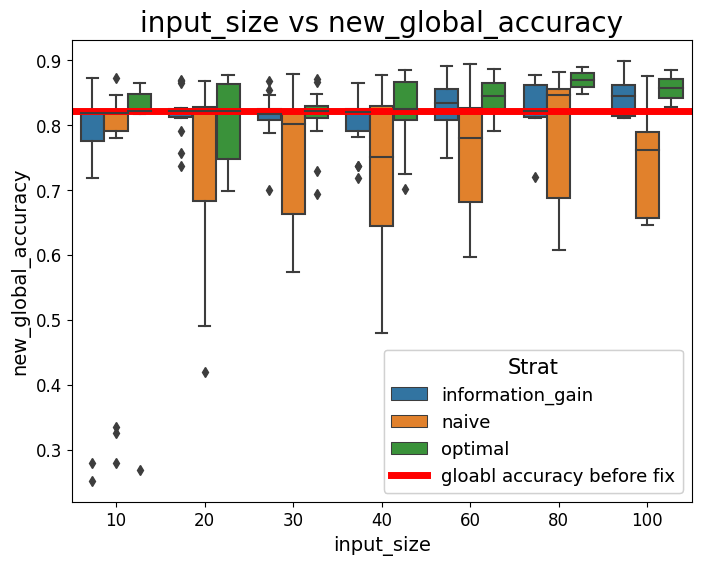

In [12]:
# scatter_plot_single_group_value(df=df_3_strats, 
#                                 x='user_input_size', 
#                                 y='new_global_accuracy', 
#                                 xlabel='input_size', 
#                                 ylabel='new_global_accuracy', 
#                                 title='input_size vs new global accuracy after fix', 
#                                 color_assignment_dict=line_color_assignment_dict,
#                                 group_col='strat',
#                                scale='linear',
#                                 xticks=[10, 20, 30, 40, 60, 80, 100])
boxplot(df=df_3_strats, 
        x='user_input_size', 
        y='new_global_accuracy', 
        xlabel='input_size', 
        ylabel='new_global_accuracy', 
        title='input_size vs new_global_accuracy', 
#         color_assignment_dict=line_color_assignment_dict,
#         group_col='strat',
       )

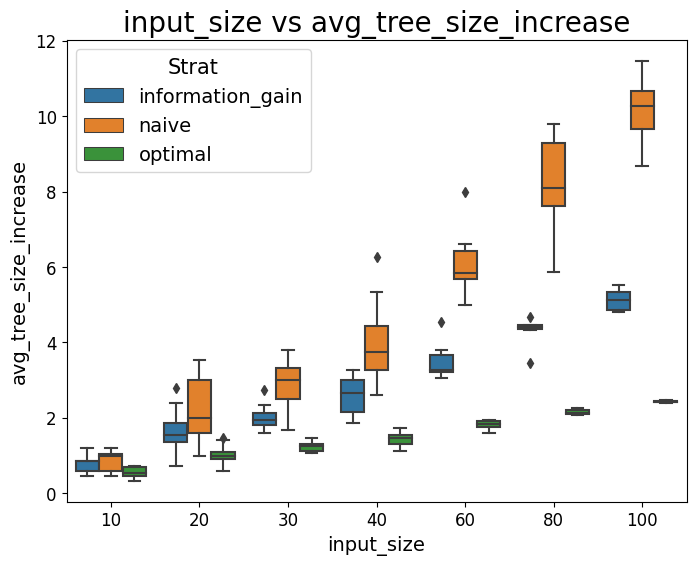

In [13]:
boxplot(df=df_3_strats, 
        x='user_input_size', 
        y='avg_tree_size_increase', 
        xlabel='input_size', 
        ylabel='avg_tree_size_increase', 
        title='input_size vs avg_tree_size_increase', 
#         color_assignment_dict=line_color_assignment_dict,
#         group_col='strat',
       )